# Library Book Recommendation System

---
## Business Understanding
In the increasingly competitive landscape of online libraries and book platforms, personalized recommendation systems have emerged as a critical tool for enhancing user engagement, satisfaction, and retention. Understanding users' unique preferences, demographics, and reading habits is essential for delivering relevant and tailored book suggestions that resonate with individual tastes. By leveraging advanced algorithms and user data analytics, our platform aims to revolutionize the book discovery experience, offering users a curated selection of books that align with their interests and preferences. Through continuous iteration and optimization, we strive to create a dynamic and immersive user interface that not only facilitates book exploration but also fosters a sense of community and interaction among readers, ultimately driving business growth and differentiation in the competitive market.


---
## Problem Statement

The current landscape of online libraries and book platforms lacks personalized recommendation systems that effectively cater to individual users' preferences and reading habits. Existing platforms often rely on generic recommendations or fail to leverage user data to deliver relevant book suggestions, leading to suboptimal user experiences and limited engagement. Our platform aims to address this challenge by developing a robust and intuitive recommendation system that harnesses user data, ratings, and book information to provide personalized book recommendations tailored to each user's unique profile. By seamlessly integrating user registration, profile creation, and recommendation display functionalities into the user interface, we seek to empower users to discover new books that align with their interests and preferences while fostering a vibrant and engaging community of readers.

### Project Objectives
$i.$ Develop a personalized book recommendation engine that utilizes user data, ratings, and book information to generate tailored book suggestions for individual users based on their preferences, demographics, and reading history.

$ii.$ **Create User-Friendly Interface:** Develop an intuitive and user-friendly interface that facilitates seamless user registration, profile creation, and recommendation display. 

### Metrics Of Success

The success of our recommendation engine lies in delivering personalized content to every book lover on our platform, as reflected by high conversion rates of the content provided to users. While the industry standard for mean absolute error (MAE) is 0.5, we aim to surpass these expectations by developing a recommendation engine with a maximum MAE of 0.3. This commitment ensures that our engine consistently provides accurate and tailored book suggestions, exceeding industry benchmarks and enhancing user satisfaction and engagement.



---
## Data Understanding

The data used in this project was obtained from [Kaggle](https://www.kaggle.com/code/fahadmehfoooz/book-recommendation-system/input?select=Books.csv). 
It comprises three different tables:

`Ratings`<br>
Contains the book rating information. Ratings (`Book-Rating`) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

`Books`<br>
Books are identified by their respective `ISBN`. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (`Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon web site.

`Users`<br>
Contains the users. Note that user IDs (`User-ID`) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL-values.


Additional data was obtained from [Google Books API](https://developers.google.com/books).

In [153]:
#Importing 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import re


**Loading Data**

In [154]:
#From Kaggle
#importing Ratings datasets
ratings = pd.read_csv('data/Ratings.csv', encoding= 'latin-1')

# importing users dataset
users = pd.read_csv('data/Users.csv', encoding= 'latin-1', on_bad_lines= 'skip')

# importing books datasets
books = pd.read_csv('data/Books.csv', encoding='latin-1', on_bad_lines='skip')

#importing the books queried from google books API
api_books = pd.read_csv('data/apibooks.csv')


C:\Users\KennedyOdhiambo\AppData\Local\Temp\ipykernel_9756\939999158.py:9: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('data/Books.csv', encoding='latin-1', on_bad_lines='skip')


**Ratings**

In [155]:
#exploring the dataset
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [156]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [157]:
#checking for duplicates
ratings.duplicated().sum()

0

In [158]:
#checking for number of unique users
ratings['User-ID'].nunique()

105283

In [159]:
#checking for unique books
ratings['ISBN'].nunique()

340556

For the rating dataset;
- The dataset has 3 features with **1,149,780** records
- The dataset has 105,283 unique users and 340556 different books rated by the users
- There are no missing values
- There are no duplicates

**Books**

In [160]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [161]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [162]:
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [163]:
#checking duplicates
books.duplicated().sum()

0

**Users**

In [164]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [165]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [166]:
users.isna().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

### Data Cleaning

**Users table**

The age columns has over 110,000 missing values therefore dropping all these records will lead to loss of monumental information about the users which we can't afford to lose.

In [167]:
import warnings
warnings.filterwarnings(category = FutureWarning, action = 'ignore')

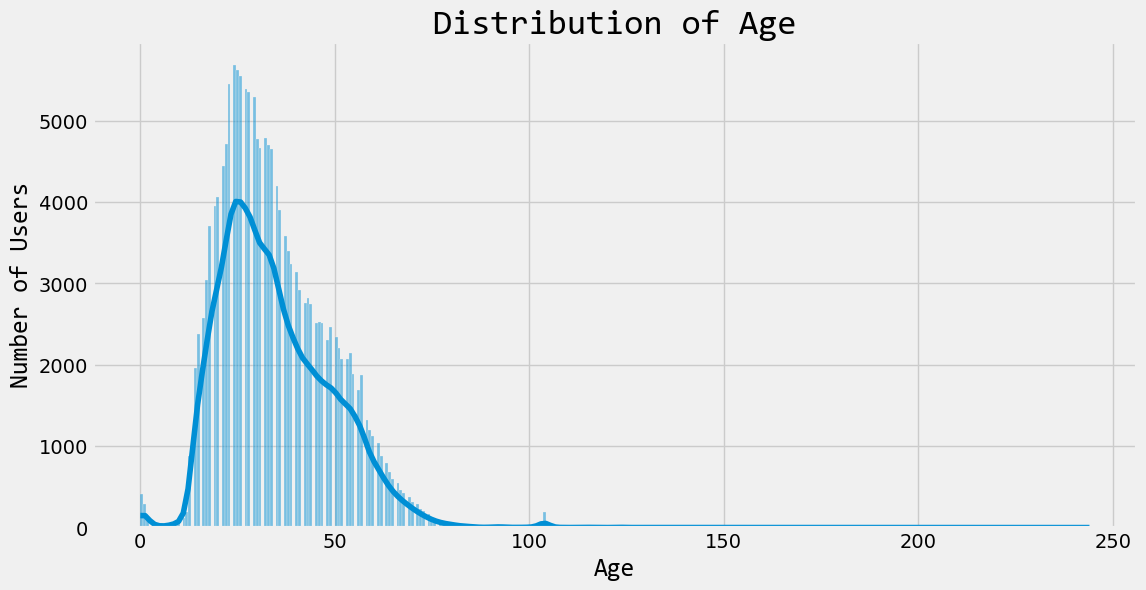

In [168]:
#examining the distribution of `age` column
fig, ax = plt.subplots(figsize = (12, 6))
sns.histplot(data= users, x= 'Age', kde= True)
ax.set_title('Distribution of Age', fontname='Consolas', fontsize = 25)
ax.set_xlabel('Age', fontname='Consolas', fontsize=18)
ax.set_ylabel('Number of Users', fontname='Consolas', fontsize=18);

Since the data is highly skewed, replacing the missing values with the mean wouldn't be ideal for this project. Instead, the missing values will be replaced by the median value, as it is not susceptible to the outliers.

In [169]:
#replacing the missing values
users['Age'].fillna(users['Age'].median(), inplace= True)

In [170]:
#sanity check
users.isna().sum()

User-ID     0
Location    0
Age         0
dtype: int64

From the histogram plot, it is observed that there are users with ages as low as 0 and as high as 250. However, in an ideal world, currently with advanced technology, it is assumed that the minimum age for a child to start reading by themselves would be 5 years. Additionally, individuals over 100 years would be least likely to read by themselves or interact with technology. For this project, ages below five years and over 100 years will be treated as most likely placeholders. They will be replaced with the median age.

In [171]:
# replacing the users with less than 5 year and over 100 years with median

users.loc[(users['Age'] < 5) | (users['Age'] > 100)] = users['Age'].median()

In [172]:
#previewing the dataset again
users.sample(10)

,User-ID,Location,Age
54160,54161,"perth, ontario, canada",32.0
256604,256605,"madrid, comunidad de madrid, spain",44.0
275759,275760,"charlottetown, prince edward island, canada",32.0
107900,107901,"brescia, lombardia, italy",29.0
251909,251910,"arlington, virginia, usa",32.0
249582,249583,"league city, texas, usa",38.0
166806,166807,"ottawa, ontario, canada",32.0
217032,217033,"houston, texas, usa",32.0
112000,112001,"barren springs, virginia, usa",43.0
177375,177376,"malvern, pennsylvania, usa",32.0


In this project's analysis, the Country will be extracted from the `Location` column. Records with unidentifiable countries will have their null values replaced with `Other`, instead of being dropped.

In [173]:
# splitting a string into a list
users['Country'] = users['Location'].str.split(", ", expand = True)[2].str.strip()

#replacing the none countries with other

users['Country'].fillna('Other', inplace =  True)

In [174]:
#sanity check
users['Country'].isna().sum()

0

In [175]:
#dropping the location column

users.drop(columns = ['Location'], inplace = True)

In [176]:
#previewin the users table again

users.head()

,User-ID,Age,Country
0,1,32.0,usa
1,2,18.0,usa
2,3,32.0,russia
3,4,17.0,portugal
4,5,32.0,united kingdom


Books Table

In [177]:
books.sample(6)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
253654,043908721X,Read to Me: Raising Kids Who Love to Read,Bernice E. Cullinan,2000,Scholastic,http://images.amazon.com/images/P/043908721X.0...,http://images.amazon.com/images/P/043908721X.0...,http://images.amazon.com/images/P/043908721X.0...
218177,0553298348,Resurrection,Katharine Kerr,1992,Bantam Books,http://images.amazon.com/images/P/0553298348.0...,http://images.amazon.com/images/P/0553298348.0...,http://images.amazon.com/images/P/0553298348.0...
100660,3499132648,Harrouda.,Tahar BenJelloun,1993,Rowohlt Tb.,http://images.amazon.com/images/P/3499132648.0...,http://images.amazon.com/images/P/3499132648.0...,http://images.amazon.com/images/P/3499132648.0...
256620,0695316710,Maria and Mr. Feathers,Hannah Kimball,1982,Follett Pub. Co,http://images.amazon.com/images/P/0695316710.0...,http://images.amazon.com/images/P/0695316710.0...,http://images.amazon.com/images/P/0695316710.0...
163271,0399140778,The Beast: A Reckoning With Depression,Tracy Thompson,1995,Putnam Pub Group,http://images.amazon.com/images/P/0399140778.0...,http://images.amazon.com/images/P/0399140778.0...,http://images.amazon.com/images/P/0399140778.0...
167849,1557830436,On Singing Onstage (Applause Acting Series),David Craig,1990,Applause Books,http://images.amazon.com/images/P/1557830436.0...,http://images.amazon.com/images/P/1557830436.0...,http://images.amazon.com/images/P/1557830436.0...


The International Standard Book Number (ISBN) is a numeric commercial book identifier that is intended to be unique. ISBNs are purchased or received by publishers from an affiliate of the International ISBN Agency. The ISBN is ten digits long if assigned before 2007 and thirteen digits long if assigned on or after 1 January 2007. However, the data utilized in this project was collected in 2004, therefore, ISBNs less than 10 digits or more than 10 would be expected to be invalid.

In [178]:
#removing the whitespaces if there is any and lower all alphabets the the ISBNS
books['ISBN'] = books['ISBN'].str.replace(' ', '').str.lower()

In [179]:
#Identifying duplicate ISBN
books['ISBN'].duplicated().sum()

314

Since ISBNs are intended to be unique for each book, all the duplicated ISBNs are dropped.

In [180]:
#dropping the duplicates
books.drop_duplicates(subset=["ISBN"], inplace=True)

In [181]:
#sanity check
books['ISBN'].duplicated().sum()

0

In [182]:
#Identifying with ISBNS less than 10 and more than 10
books.loc[(books['ISBN'].apply(lambda x: len(x) > 10)) | (books['ISBN'].apply(lambda x: len(x) < 10))]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
111808,0486404242\t,War in Kind: And Other Poems (Dover Thrift Edi...,Stephen Crane,1998,Dover Publications,http://images.amazon.com/images/P/0486404242.0...,http://images.amazon.com/images/P/0486404242.0...,http://images.amazon.com/images/P/0486404242.0...
171206,3518365479<90,"Suhrkamp TaschenbÃ?ÃÂ¼cher, Nr.47, Frost",Thomas Bernhard,1972,Suhrkamp,http://images.amazon.com/images/P/3518365479.0...,http://images.amazon.com/images/P/3518365479.0...,http://images.amazon.com/images/P/3518365479.0...
251424,34422480273,Diamond Age. Die Grenzwelt.,Neal Stephenson,2000,Goldmann,http://images.amazon.com/images/P/3442248027.0...,http://images.amazon.com/images/P/3442248027.0...,http://images.amazon.com/images/P/3442248027.0...
251649,03857222060,Balzac and the Little Chinese Seamstress : A N...,DAI SIJIE,2002,Anchor,http://images.amazon.com/images/P/0385722206.0...,http://images.amazon.com/images/P/0385722206.0...,http://images.amazon.com/images/P/0385722206.0...


In [183]:
#droping the records
books.drop(books.loc[(books['ISBN']
                      .apply(lambda x: len(x) > 10)) | (books['ISBN']
                                                        .apply(lambda x: len(x) < 10))].index, inplace=True)

In [184]:
#sanity check
books.loc[(books['ISBN'].apply(lambda x: len(x) > 10)) | (books['ISBN'].apply(lambda x: len(x) < 10))]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L


In [185]:
#previewing the the cleaned books
books.sample(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
158737,0892551658,Our House in the Last World,Oscar Hijuelos,1991,W W Norton &amp; Co,http://images.amazon.com/images/P/0892551658.0...,http://images.amazon.com/images/P/0892551658.0...,http://images.amazon.com/images/P/0892551658.0...
54872,0452265762,Martha Quest,Doris May Lessing,1993,Penguin USA,http://images.amazon.com/images/P/0452265762.0...,http://images.amazon.com/images/P/0452265762.0...,http://images.amazon.com/images/P/0452265762.0...
136318,0890439605,Consumer Reports Buying Guide 2002 (Consumer R...,Consumer Reports,2001,Consumer Reports Books,http://images.amazon.com/images/P/0890439605.0...,http://images.amazon.com/images/P/0890439605.0...,http://images.amazon.com/images/P/0890439605.0...
150655,1569473269,The House Sitter,Peter Lovesey,2003,Soho Press,http://images.amazon.com/images/P/1569473269.0...,http://images.amazon.com/images/P/1569473269.0...,http://images.amazon.com/images/P/1569473269.0...
119242,1555911668,Meant to Be Wild: The Struggle to Save Endange...,Jan Deblieu,1993,Fulcrum Publishing,http://images.amazon.com/images/P/1555911668.0...,http://images.amazon.com/images/P/1555911668.0...,http://images.amazon.com/images/P/1555911668.0...


Api books

In [186]:
#previewing the api books
api_books.head()

,authors,published_date,description,isbn_10,isbn_13,page_count,categories,maturity_rating,language,join_isbn_10
0,"['Mark P. O. Morford', 'Robert J. Lenardon']",2003,Provides an introduction to classical myths pl...,0195153448,9780195153446.0,808.0,['Social Science'],NOT_MATURE,en,0195153448
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0002005018
2,"[""Carlo D'Este""]",1991,"Here, for the first time in paperback, is an o...",IND:30000026059836,NaN,582.0,['1940-1949'],NOT_MATURE,en,0060973129
3,['Gina Bari Kolata'],1999,"Describes the great flu epidemic of 1918, an o...",9780374157067,374157065.0,367.0,['Medical'],NOT_MATURE,en,0374157065
4,['E. J. W. Barber'],1999,A look at the incredibly well-preserved ancien...,0393045218,9780393045215.0,240.0,['Design'],NOT_MATURE,en,0393045218


In [187]:
#dropping the ISBN_10 and ISBN_13 since we shall use the last column join_isbn_10
api_books.drop(columns= ['isbn_10','isbn_13'], inplace= True)

In [188]:
api_books.head()

,authors,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10
0,"['Mark P. O. Morford', 'Robert J. Lenardon']",2003,Provides an introduction to classical myths pl...,808.0,['Social Science'],NOT_MATURE,en,0195153448
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0002005018
2,"[""Carlo D'Este""]",1991,"Here, for the first time in paperback, is an o...",582.0,['1940-1949'],NOT_MATURE,en,0060973129
3,['Gina Bari Kolata'],1999,"Describes the great flu epidemic of 1918, an o...",367.0,['Medical'],NOT_MATURE,en,0374157065
4,['E. J. W. Barber'],1999,A look at the incredibly well-preserved ancien...,240.0,['Design'],NOT_MATURE,en,0393045218


In [189]:
#merging the books from api and the cleaned books
book_df = books.merge(right= api_books, how= 'inner', right_on= 'join_isbn_10', left_on= 'ISBN')

In [190]:
book_df.shape

(249026, 16)

In [191]:
#previewing the merged books df

book_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,"['Mark P. O. Morford', 'Robert J. Lenardon']",2003,Provides an introduction to classical myths pl...,808.0,['Social Science'],NOT_MATURE,en,0195153448
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0002005018
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,"[""Carlo D'Este""]",1991,"Here, for the first time in paperback, is an o...",582.0,['1940-1949'],NOT_MATURE,en,0060973129
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,['Gina Bari Kolata'],1999,"Describes the great flu epidemic of 1918, an o...",367.0,['Medical'],NOT_MATURE,en,0374157065
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,['E. J. W. Barber'],1999,A look at the incredibly well-preserved ancien...,240.0,['Design'],NOT_MATURE,en,0393045218


When importing the books data, it was noticed that there were mixed data types. Therefore, before beginning the analysis, it would be better to examine the cause of this in the 3rd column (`Year-Of-Publication`) before proceeding with the exploratory data analysis (EDA).

In [192]:
#Checking inique values for years
book_df['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1995, 1982, 1985, 1992, 1986, 1978, 1980, 1983, 1952,
       1987, 1981, 1990, 1989, 1984, 0, 1968, 1961, 1958, 1974, 1976,
       1971, 1977, 1975, 1965, 1941, 1970, 1962, 1972, 1960, 1979, 1966,
       1920, 1973, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1950,
       1967, 2005, 1957, 1937, 1955, 1954, 1946, 1930, 2011, 1925, 1948,
       1943, 1947, 1923, 1939, 1926, 1938, 2030, 1940, 1911, 1949, 1932,
       1928, 1929, 1945, 1927, 1936, 1931, 1914, 2050, 1934, 1910, 1933,
       1902, 1924, 1921, 2038, 2026, 1944, 1917, 1901, 2010, 1908, 1906,
       1935, 1806, 2021, '2000', '1995', '1999', '2003', '1990', '1994',
       '1986', '1989', '2002', '1981', '1993', '1983', '1982', '1976',
       '1991', '1977', '1998', '1992', '0', '2001', '1997', '1996',
       '2004', '1968', '1987', '1984', '1988', '1963', '1956', '1974',
       '1970', '1985', '1978', '1973', '1980', '1979', '1961', 

It is noticed that there are values such as `DK Publishing Inc` and `Gallimard`, which are not ideal for years. Therefore, the rows with these values will be examined.

In [193]:
#previewing the records with wrong years
book_df.loc[(book_df['Year-Of-Publication'] == 'DK Publishing Inc') 
            | (book_df['Year-Of-Publication'] == 'Gallimard')]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10
202625,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN,['Jean-Marie Gustave Le ClÃ©zio'],2002,Deux enfants vivent une expÃ©rience qui boulev...,132.0,['Fiction'],NOT_MATURE,fr,2070426769
203486,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN,"['James Buckley (Jr.)', 'Michael Teitelbaum']",2000,"Meet the artists, writers and others who make ...",54.0,['Graphic novels'],NOT_MATURE,en,0789466953


Instead of dropping these records, the `Book-Author`, `Year-Of-Publication`, and `Publisher` columns will be fixed for these records using the available information. It is noticed that the year of publication was moved to the book author column at the time of recording, while the publisher was recorded in the year of publication column. The book author can be found from the authors column.

In [194]:
#fixing the mislabeled records
publication_dict = {'DK Publishing Inc': 2000,
                    'Gallimard': 2003}

#year of publication
book_df['Year-Of-Publication'].replace(publication_dict, inplace= True)

#Fixing book author
book_df.iloc[203486]['Book-Author'] = 'James Buckley (Jr.)'
book_df.iloc[202625]['Book-Author'] = 'Jean-Marie Gustave Le ClÃ©zio'

#fixing the publisher
book_df.iloc[203486]['Publisher'] = 'DK Publishing Inc'
book_df.iloc[202625]['Publisher'] = 'Gallimard'


C:\Users\KennedyOdhiambo\AppData\Local\Temp\ipykernel_9756\392233048.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_df.iloc[203486]['Book-Author'] = 'James Buckley (Jr.)'
C:\Users\KennedyOdhiambo\AppData\Local\Temp\ipykernel_9756\392233048.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_df.iloc[202625]['Book-Author'] = 'Jean-Marie Gustave Le ClÃ©zio'
C:\Users\KennedyOdhiambo\AppData\Local\Temp\ipykernel_9756\392233048.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [195]:
#sanity check
book_df.loc[(book_df['Year-Of-Publication'] == 'DK Publishing Inc') 
            | (book_df['Year-Of-Publication'] == 'Gallimard')]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10


In [196]:
#converting the year column to integer
book_df['Year-Of-Publication'] = book_df['Year-Of-Publication'].astype(int)

In [197]:
#Rechecking the values of years dataset
book_df['Year-Of-Publication'].value_counts().sort_index(ascending= False)[:20]

Year-Of-Publication
2050        2
2038        1
2030        7
2026        1
2024        1
2021        1
2012        1
2011        2
2010        2
2006        3
2005       39
2004     5347
2003    13086
2002    16103
2001    15851
2000    15748
1999    15951
1998    14512
1997    13648
1996    12907
Name: count, dtype: int64

#

Considering that the main dataset utilized in this project was collected in 2004, it's essential to inspect the columns containing years above 2004.

In [198]:
#inspecting the columns that have years above 2004

book_df.loc[book_df['Year-Of-Publication'] > 2004].sample(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10
230410,0316156108,The Ha-Ha : A Novel,Dave King,2005,"Little, Brown",http://images.amazon.com/images/P/0316156108.0...,http://images.amazon.com/images/P/0316156108.0...,http://images.amazon.com/images/P/0316156108.0...,['Dave King'],2005,"Rendered unable to speak, read, or write after...",340.0,['Fiction'],NOT_MATURE,en,0316156108
100372,0881501719,The Asey Mayo Trio: Three Cape Cod Mysteries,Phoebe Atwood Taylor,2005,Countryman Press,http://images.amazon.com/images/P/0881501719.0...,http://images.amazon.com/images/P/0881501719.0...,http://images.amazon.com/images/P/0881501719.0...,['Phoebe Atwood Taylor'],2005-02,Set within the brooding landscape of Cape Code...,243.0,['Fiction'],NOT_MATURE,en,0881501719


Given the dataset's size, we can afford to lose the 72 records containing such unrealistic publication years. Therefore, we will drop all records where the year of publication is above 2004. Additionally, some dates may be unreasonable, and removing them will help ensure the dataset's quality and accuracy.

There are also records where the year of publication is 0. Given we can't have a zero year, they are problably place holders. For this project, we shall drop the records with zero as the year of publication.

In [199]:
#sling to have only records with year of publication above 0
book_df = book_df.loc[book_df['Year-Of-Publication'] > 0]

In [200]:
#sanity check
book_df.loc[book_df['Year-Of-Publication'] == 0]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10


In [201]:
#dropping some duplicate features

book_df.drop(columns= ['join_isbn_10','authors','published_date' ], inplace= True)


In [202]:
book_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244835 entries, 0 to 249025
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 244835 non-null  object 
 1   Book-Title           244835 non-null  object 
 2   Book-Author          244833 non-null  object 
 3   Year-Of-Publication  244835 non-null  int32  
 4   Publisher            244834 non-null  object 
 5   Image-URL-S          244835 non-null  object 
 6   Image-URL-M          244835 non-null  object 
 7   Image-URL-L          244833 non-null  object 
 8   description          163922 non-null  object 
 9   page_count           191322 non-null  float64
 10  categories           180410 non-null  object 
 11  maturity_rating      192535 non-null  object 
 12  language             192535 non-null  object 
dtypes: float64(1), int32(1), object(11)
memory usage: 25.2+ MB


- **Handling the categories column**



In [203]:
book_df.sample(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,description,page_count,categories,maturity_rating,language
150876,0844263869,Careers for Introverts &amp; Other Solitary Types,Blythe Camenson,1999,McGraw-Hill,http://images.amazon.com/images/P/0844263869.0...,http://images.amazon.com/images/P/0844263869.0...,http://images.amazon.com/images/P/0844263869.0...,Explores professions suitable for people who p...,129.0,['Business & Economics'],NOT_MATURE,en
148992,0517006766,Ancestors,Robert Kline,1988,Random House Inc,http://images.amazon.com/images/P/0517006766.0...,http://images.amazon.com/images/P/0517006766.0...,http://images.amazon.com/images/P/0517006766.0...,Toby Horton has a gift--the gift of traveling ...,388.0,['Fiction'],NOT_MATURE,en
87533,0099279444,The BRIDESMAID/TO FEAR A PAINTED,RUTH RENDELL,1998,Random House UK Ltd (A Division of Random Hous...,http://images.amazon.com/images/P/0099279444.0...,http://images.amazon.com/images/P/0099279444.0...,http://images.amazon.com/images/P/0099279444.0...,NaN,508.0,NaN,NOT_MATURE,en
153738,0060907851,Sleepers Joining Hands (Harper colophon books),Robert Bly,1991,Harpercollins,http://images.amazon.com/images/P/0060907851.0...,http://images.amazon.com/images/P/0060907851.0...,http://images.amazon.com/images/P/0060907851.0...,NaN,67.0,['Poetry'],NOT_MATURE,en
225598,0671660934,The Paradise of Bombs (Touchstone Books (Paper...,Scott Russell Sanders,1988,Simon &amp; Schuster,http://images.amazon.com/images/P/0671660934.0...,http://images.amazon.com/images/P/0671660934.0...,http://images.amazon.com/images/P/0671660934.0...,NaN,NaN,NaN,NaN,NaN


In [204]:
#Replacing the null values with Undefined
book_df['categories'].fillna('Undefined', inplace= True)

In [205]:
# Removing unwanted characters and split the string into a list
book_df['categories'] = book_df['categories'] \
                            .str.replace("[", "") \
                            .str.replace("]", "") \
                            .str.replace("'", "") \
                            .str.replace('"', "") \
                            .str.split(", ") 
#exploding the list of categories to individual categories in new rows
book_df = book_df.explode(column= 'categories', ignore_index= True)

- Handling  page count column

In [206]:
#replacing page count with median page count

book_df['page_count'].fillna(book_df['page_count'].median(), inplace= True)

- Handling description column

In [207]:
#dropping the records with missng values in description column
book_df.dropna(subset= ['description'], inplace = True)

In [208]:
book_df.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              1
Image-URL-S            0
Image-URL-M            0
Image-URL-L            2
description            0
page_count             0
categories             0
maturity_rating        0
language               0
dtype: int64

In [209]:
#dropping the remaining missing value

book_df.dropna(inplace= True)

In [210]:
#sanity check
book_df.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
description            0
page_count             0
categories             0
maturity_rating        0
language               0
dtype: int64

- Sorting the maturity rating and Languange

In [211]:
# capitalizing the maturity rangings

book_df['maturity_rating'] = book_df['maturity_rating'].str.capitalize()

#language abreviation to upper case

book_df['language'] = book_df['language'].str.upper()

**Rating Table**

In [212]:
ratings.shape

(1149780, 3)

In [213]:
#preview the dataset
ratings.sample(5)

,User-ID,ISBN,Book-Rating
29343,6703,8485224051,0
419953,100410,088798317040,9
231939,53477,0380814021,10
467453,111888,0312950586,8
735307,177458,0743445627,8


In [214]:
#removing the whitespaces if there is any and lower all alphabets the the ISBNS
ratings['ISBN'] = ratings['ISBN'].str.replace(' ', '').str.lower()

In [215]:
#checking the ISBN if correct
ratings.loc[(ratings['ISBN'].apply(lambda x: len(x) > 10 )) | (ratings['ISBN'].apply(lambda x: len(x) < 10))]

,User-ID,ISBN,Book-Rating
9,276745,342310538,10
40,276762,342662429,0
55,276762,n3453124715,4
247,276856,20103389,0
291,276861,344242529,9
...,...,...,...
1149238,276641,033031582,5
1149358,276670,00969754916,7
1149428,276670,15655122046,6
1149439,276670,55305663,6


In [216]:
#droping the invalid ISBN
ratings.drop(ratings.loc[(ratings['ISBN']
                      .apply(lambda x: len(x) > 10)) | (ratings['ISBN']
                                                        .apply(lambda x: len(x) < 10))].index, inplace=True)

In [217]:
#Sanity check
ratings.loc[(ratings['ISBN'].apply(lambda x: len(x) > 10 )) | (ratings['ISBN'].apply(lambda x: len(x) < 10))]

,User-ID,ISBN,Book-Rating


In the data description, it was observed that explicit ratings were provided by users to express their sentiments toward a book, using a scale of 1 to 10. Additionally, implicit ratings were denoted by a zero. For this project, the explicit ratings from each user will be utilized, as they provide insight into the user's emotional response to the content they have engaged with. This decision is based on the understanding that explicit ratings convey the user's feelings more directly compared to implicit ratings, which may not necessarily reflect their sentiment accurately.

In [218]:
#segragating only explicit ratings
ratings_explicit = ratings.loc[ratings['Book-Rating'] != 0]

- Merging the users table to rating table

In [219]:
#merging on User-ID
users_and_rating = users.merge(right= ratings_explicit, on= 'User-ID')
users_and_rating.shape

(428016, 5)

In [220]:
users_and_rating.isna().sum()

User-ID        0
Age            0
Country        0
ISBN           0
Book-Rating    0
dtype: int64

- Merging users and ratings with cleaned books

In [221]:
#merging on ISBN

final_df = users_and_rating.merge(right= book_df, on= 'ISBN')

final_df.shape

(286533, 17)

In [222]:
#previwing sample 

final_df.sample(10)

,User-ID,Age,Country,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,description,page_count,categories,maturity_rating,language
48031,190374,38.0,canada,0316789844,8,Resistance : A Novel,Anita Shreve,1997,Back Bay Books,http://images.amazon.com/images/P/0316789844.0...,http://images.amazon.com/images/P/0316789844.0...,http://images.amazon.com/images/P/0316789844.0...,This tale of impossible love--told with the sa...,256.0,Fiction,Not_mature,EN
223519,98391,52.0,usa,0312270984,8,Home to Trinity: A Novel,Delia Parr,2003,St. Martin's Press,http://images.amazon.com/images/P/0312270984.0...,http://images.amazon.com/images/P/0312270984.0...,http://images.amazon.com/images/P/0312270984.0...,"Come home to friendship, family, and faith in ...",352.0,Fiction,Not_mature,EN
81546,155711,51.0,usa,0812551699,7,The Merlin Effect,T. A. Barron,1996,Tor Fantasy,http://images.amazon.com/images/P/0812551699.0...,http://images.amazon.com/images/P/0812551699.0...,http://images.amazon.com/images/P/0812551699.0...,When she joins her father and several others i...,260.0,Fiction,Not_mature,EN
108265,11676,32.0,n/a,0590115073,8,Winter is here!,Kimberly Weinberger,1997,Scholastic Inc,http://images.amazon.com/images/P/0590115073.0...,http://images.amazon.com/images/P/0590115073.0...,http://images.amazon.com/images/P/0590115073.0...,Children are playing outside in the snow.,23.0,Snow,Not_mature,EN
218852,92498,32.0,australia,0060936827,7,Nectar : A Novel of Temptation,Lily Prior,2003,Ecco,http://images.amazon.com/images/P/0060936827.0...,http://images.amazon.com/images/P/0060936827.0...,http://images.amazon.com/images/P/0060936827.0...,"Ramona Drottoveo, an albino, is a chambermaid ...",272.0,Fiction,Not_mature,EN
249575,197515,32.0,usa,0747263612,6,Belladonna At Belstone,Michael Jecks,2000,Headline Book Publishing,http://images.amazon.com/images/P/0747263612.0...,http://images.amazon.com/images/P/0747263612.0...,http://images.amazon.com/images/P/0747263612.0...,"It's 1321 and Lady Elizabeth of Topsham, prior...",332.0,Fiction,Not_mature,EN
47259,179147,32.0,usa,0767902890,4,The Things They Carried,TIM O'BRIEN,1998,Broadway,http://images.amazon.com/images/P/0767902890.0...,http://images.amazon.com/images/P/0767902890.0...,http://images.amazon.com/images/P/0767902890.0...,Heroic young men carry the emotional weight of...,274.0,Fiction,Not_mature,EN
260367,175510,32.0,germany,3455026516,9,Die Herzogin der Bloomsbury Street,Helene Hanff,2003,"Hoffmann und Campe, Verlag",http://images.amazon.com/images/P/3455026516.0...,http://images.amazon.com/images/P/3455026516.0...,http://images.amazon.com/images/P/3455026516.0...,Gleichsam Ã¼ber Nacht wird die amerikanische A...,207.0,Undefined,Not_mature,DE
17370,257800,32.0,usa,0060930535,7,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999,Perennial,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...,"Nathan Price, a evangelical Baptist who in 195...",302.0,Fiction,Not_mature,EN
158603,30511,32.0,netherlands,0803287119,8,A Lady's Experiences in the Wild West in 1883,Rose Pender,1985,University of Nebraska Press,http://images.amazon.com/images/P/0803287119.0...,http://images.amazon.com/images/P/0803287119.0...,http://images.amazon.com/images/P/0803287119.0...,"""A very intelligent, spirited woman who saw re...",136.0,Biography & Autobiography,Not_mature,EN


In [223]:
final_df.isna().sum()

User-ID                0
Age                    0
Country                0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
description            0
page_count             0
categories             0
maturity_rating        0
language               0
dtype: int64

## Exploratory Data Analysis

**Users**

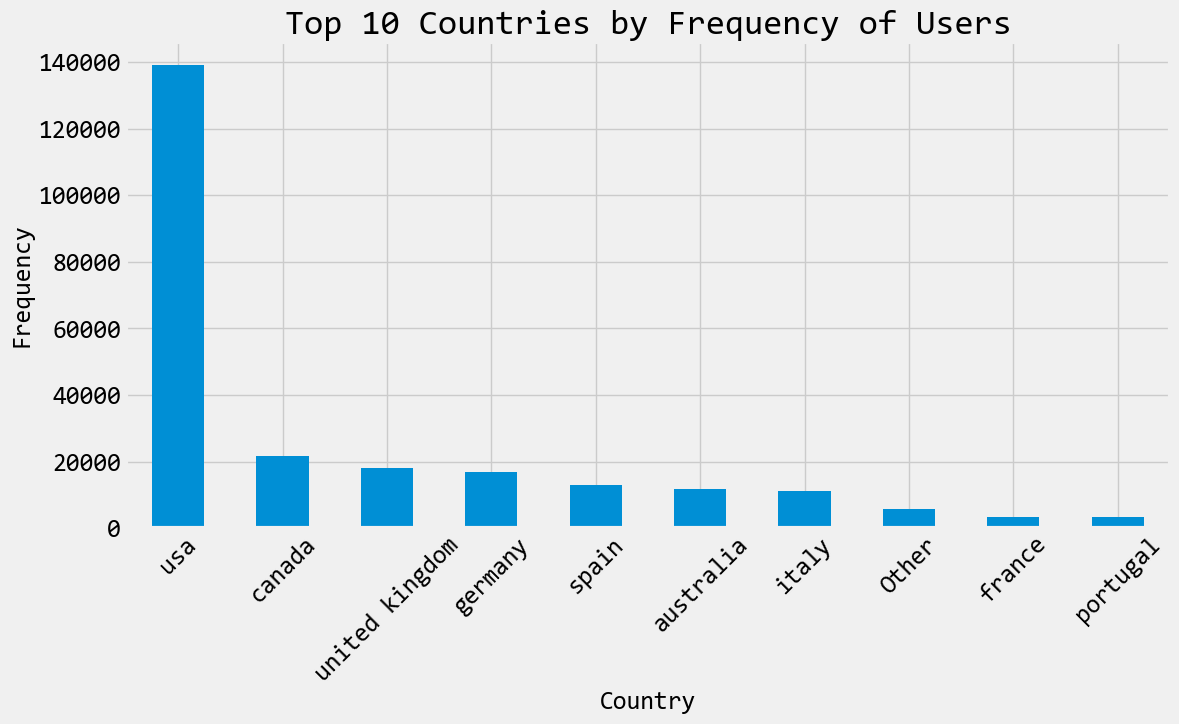

In [224]:
# Univariate Analysis for 'Country'
# Get the top 10 countries by frequency of users
top_10_countries = users['Country'].value_counts().head(10).index

# Filter the dataset to include only the top 10 countries
users_top_10_countries = users[users['Country'].isin(top_10_countries)]

# Plot the frequency of users for the top 10 countries
plt.figure(figsize=(12, 6))
users_top_10_countries['Country'].value_counts().plot(kind='bar', )
plt.title('Top 10 Countries by Frequency of Users',  fontname='Consolas', fontsize = 25)
plt.xlabel('Country', fontname='Consolas', fontsize=18)
plt.ylabel('Frequency', fontname='Consolas', fontsize=18)
plt.xticks(rotation=45, fontname='Consolas', fontsize=18)
plt.yticks(fontname='Consolas', fontsize=18)
plt.show()

**Books**

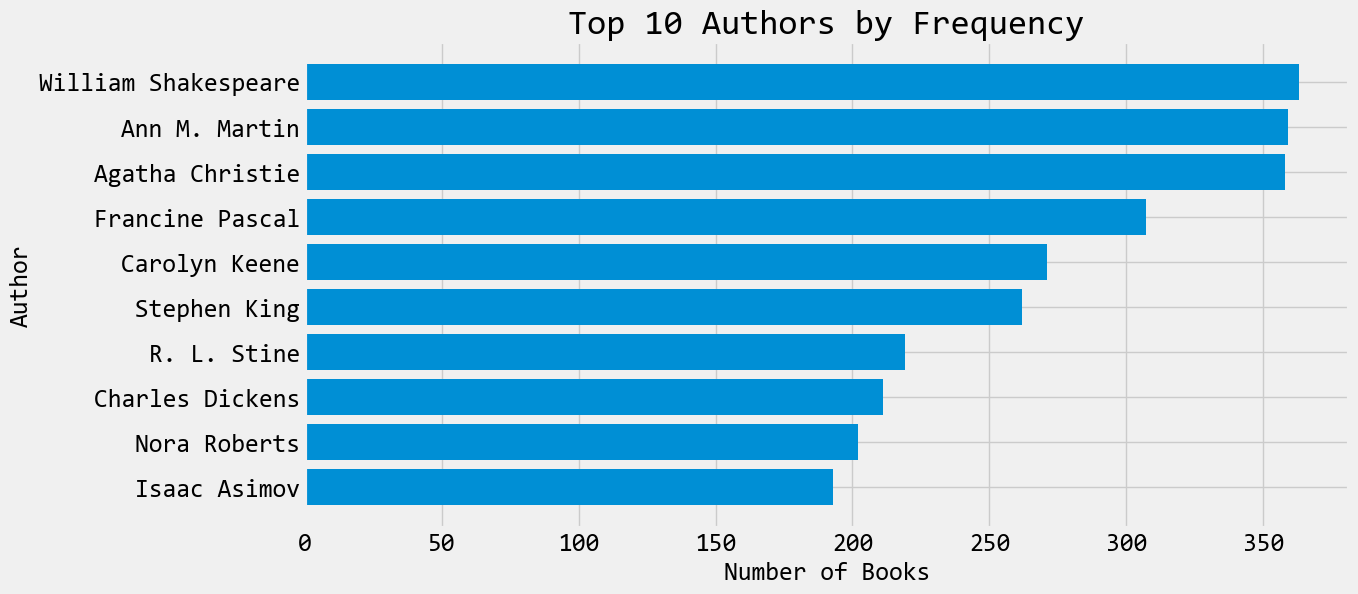

In [225]:
# Top 10 authors 
plt.figure(figsize=(12, 6))
top_authors = book_df['Book-Author'].value_counts().head(10)
top_authors = top_authors.iloc[::-1]  
plt.barh(y=top_authors.index, width=top_authors.values)
plt.title('Top 10 Authors by Frequency', fontname='Consolas', fontsize=25)
plt.xlabel('Number of Books', fontname='Consolas', fontsize=18)
plt.ylabel('Author', fontname='Consolas', fontsize=18)
plt.xticks(fontname='Consolas', fontsize=18)
plt.yticks(fontname='Consolas', fontsize=18)
plt.show()

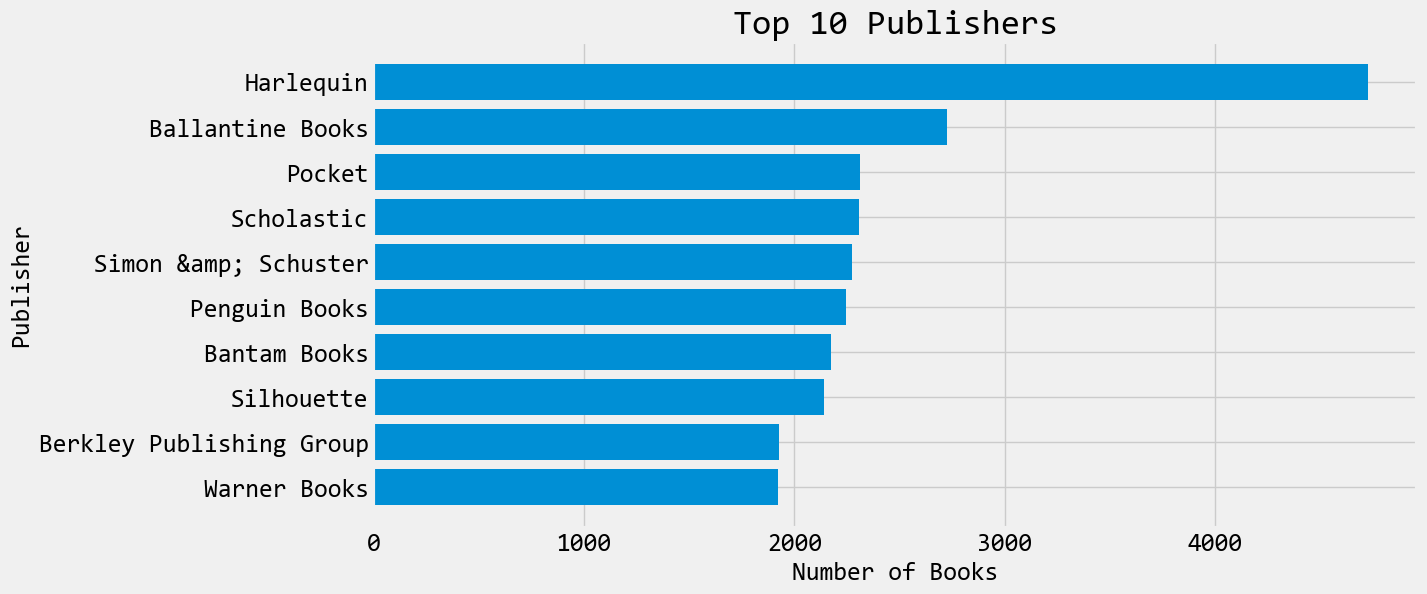

In [233]:
# Univariate Analysis for 'Publisher'
plt.figure(figsize=(12, 6))
top_publishers = book_df['Publisher'].value_counts().head(10).iloc[::-1]
plt.barh(y=top_publishers.index, width=top_publishers.values)
plt.title('Top 10 Publishers', fontname='Consolas', fontsize = 25)
plt.xlabel('Number of Books', fontname='Consolas', fontsize = 18)
plt.ylabel('Publisher', fontname='Consolas', fontsize=18)
plt.xticks(fontname='Consolas', fontsize=18)
plt.yticks(fontname='Consolas', fontsize=18)
plt.show()

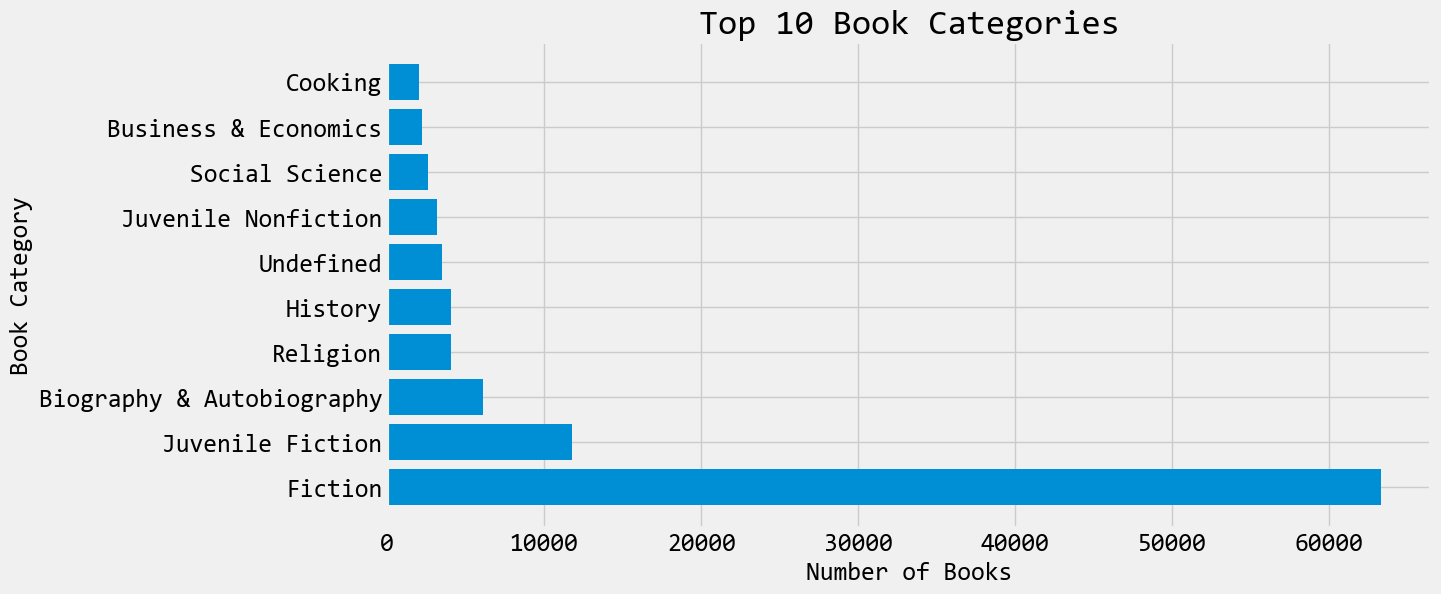

In [239]:
# Univariate Analysis for 'categories'
# Get the top 10 categories by frequency
top_10_categories = book_df['categories'].explode().value_counts().head(10)
# Plot the count plot for the top 10 categories
plt.figure(figsize=(12, 6))
plt.barh( width = top_10_categories.values, y=top_10_categories.index)
plt.title('Top 10 Book Categories', fontname='Consolas', fontsize=25)
plt.xlabel('Number of Books', fontname='Consolas', fontsize=18)
plt.ylabel('Book Category', fontname='Consolas', fontsize=18)
plt.xticks(fontname='Consolas', fontsize=18)
plt.yticks(fontname='Consolas', fontsize=18)
plt.show()

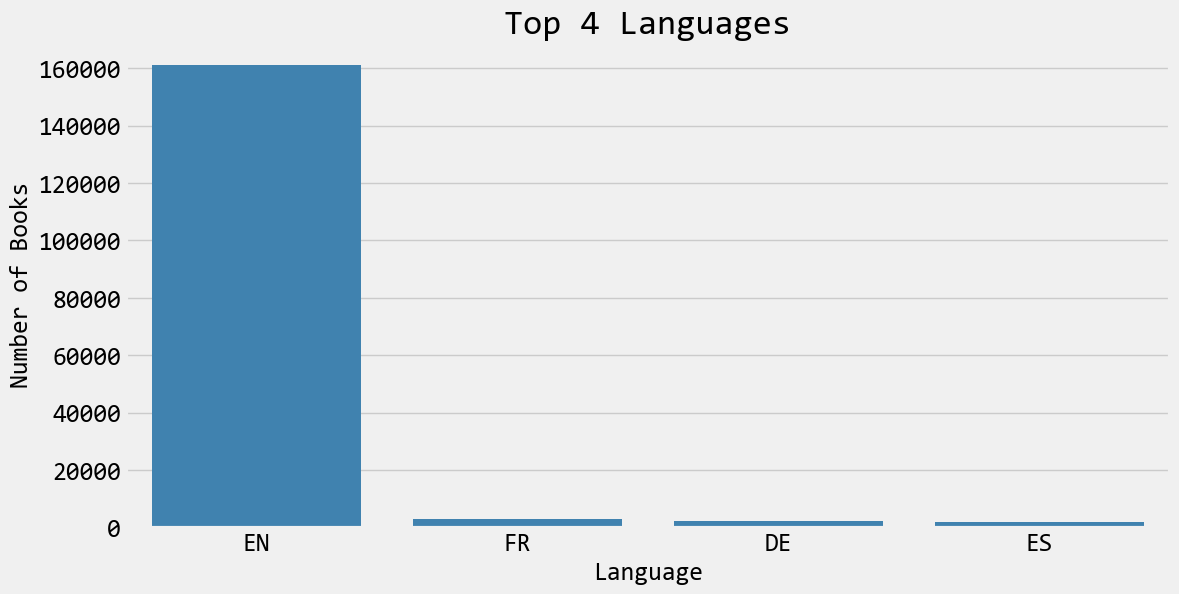

In [259]:
# Get the top 4 languages by frequency
top_4_languages = book_df['language'].value_counts().head(4).index

# Filter the dataframe to include only the top 4 languages
book_df_top_4_languages = book_df[book_df['language'].isin(top_4_languages)]

# Plot the count plot for the top 4 languages
plt.figure(figsize=(12, 6))
sns.countplot(data=book_df_top_4_languages, x='language', order=top_4_languages, color='#2E86C1')
plt.title('Top 4 Languages', fontname='Consolas', fontsize= 25)
plt.xlabel('Language', fontname='Consolas', fontsize=18)
plt.ylabel('Number of Books', fontname='Consolas', fontsize=18)
plt.xticks(fontname='Consolas', fontsize=18)
plt.yticks(fontname='Consolas', fontsize=18)
plt.show()

**Ratings**

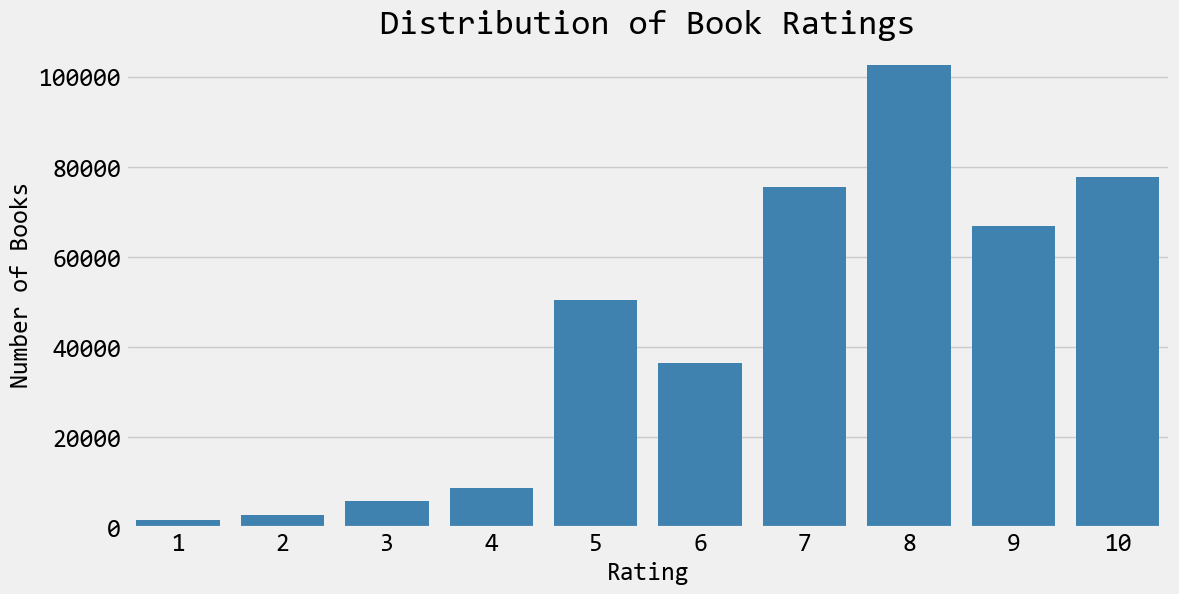

In [257]:
# Distribution of book ratings
plt.figure(figsize=(12, 6))
sns.countplot(data=ratings_explicit, x='Book-Rating', color='#2E86C1') 
plt.title('Distribution of Book Ratings', fontname='Consolas', fontsize= 25)
plt.xlabel('Rating', fontname='Consolas', fontsize=18)
plt.ylabel('Number of Books', fontname='Consolas', fontsize=18)
plt.xticks(fontname='Consolas', fontsize=18)
plt.yticks(fontname='Consolas', fontsize=18)
plt.show()

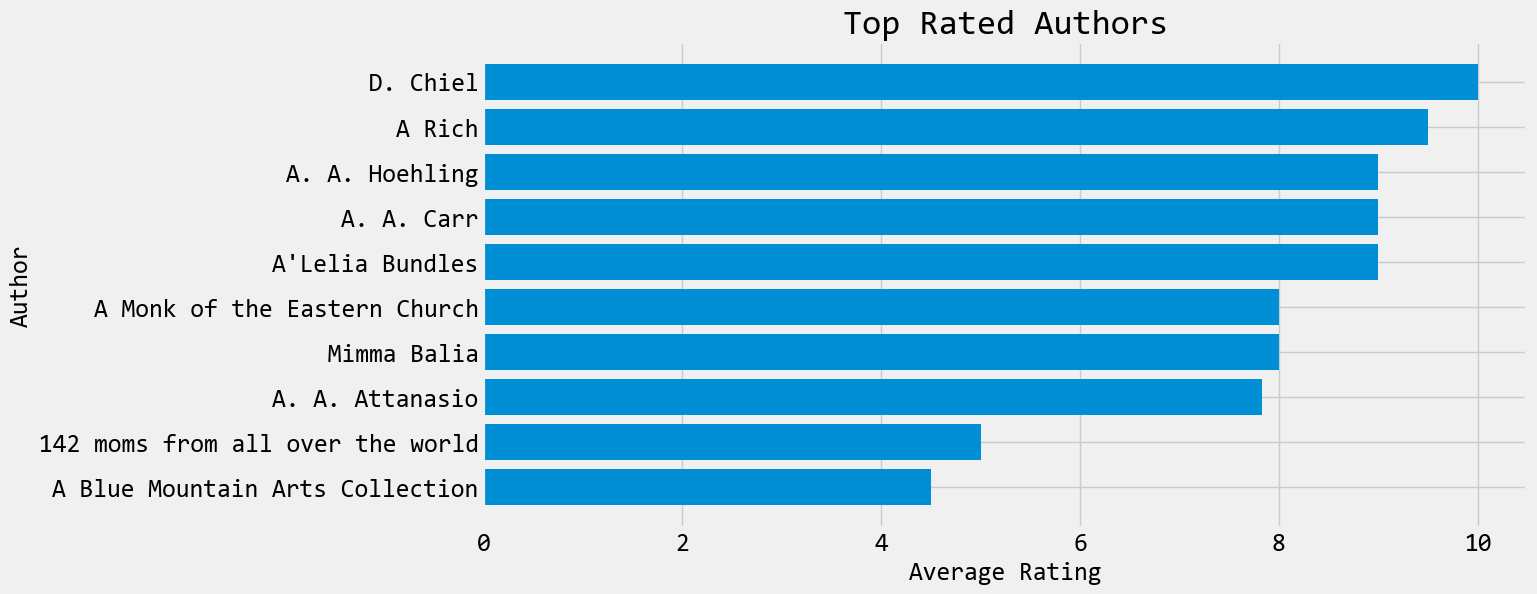

In [291]:
# Top rated authors
top_rated_authors_ = final_df.groupby(by=['Book-Author'])['Book-Rating'].mean().head(10)

# Sorting values in ascending order
top_rated_authors_sorted = top_rated_authors_.sort_values()

plt.figure(figsize = (12,6))
plt.barh(y=top_rated_authors_sorted.index, width=top_rated_authors_sorted.values)

plt.title('Top Rated Authors', fontname='Consolas', fontsize= 25)
plt.xlabel('Average Rating', fontname='Consolas', fontsize=18)
plt.ylabel('Author', fontname='Consolas', fontsize=18)
plt.xticks(fontname='Consolas', fontsize=18)
plt.yticks(fontname='Consolas', fontsize=18)
plt.show()




## Feature Engineering

***Age Grouping:*** Using the `pd.cut` function, the 'Age' column is binned into various age groups, including 'Child', 'Young Adult', 'Adult', and 'Senior'. This process results in the creation of a new categorical feature that represents the age group of each user.

In [262]:
#creating age group column
final_df['age_group'] = (pd.cut(final_df['Age'],
                                bins=[0, 18, 35, 60, 120],
                                labels=['Child', 'Young Adult', 'Adult', 'Senior']))

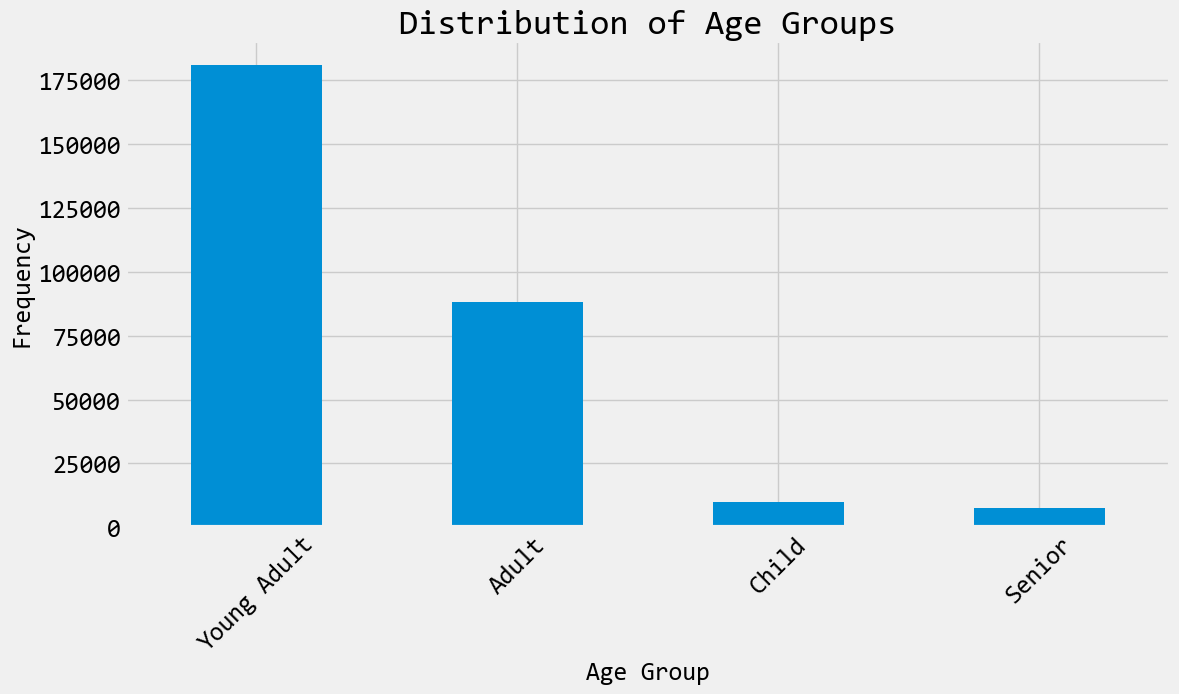

In [267]:
# Value counts for 'Age_Group' column
age_group_counts = final_df['age_group'].value_counts()

# Plot age groups
plt.figure(figsize=(12, 6))
age_group_counts.plot(kind='bar')
plt.title('Distribution of Age Groups', fontname='Consolas', fontsize= 25)
plt.xlabel('Age Group', fontname='Consolas', fontsize=18)
plt.ylabel('Frequency',fontname='Consolas', fontsize=18)
plt.xticks(rotation = 45, fontname='Consolas', fontsize=18)
plt.yticks(fontname='Consolas', fontsize=18)
plt.show()

## Modelling